## モジュールをインポート

In [1]:
import math
import copy
from multiprocessing import Pool

import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
import os
if os.getcwd() == "/content":   # 作業ディレクトリがGoogle Driveなら実行
  from google.colab import drive
  drive.mount("/content/drive")   # Google Driveをマウント
  os.chdir("/content/drive/MyDrive/Colab Notebooks/8_autoencoder_wireless_parallel")   #作業ディレクトリを移動
import module_autoencoder_ver2_4_ as ae

## 定数の設定

In [ ]:
class Constant():
    pass


# if (__name__ == '__main__'):


### 正規化規則
# 0:QAM 1:Energy 2:Average power 3:Energy-stream 4:Average power-stream
normalize_name = ("QAM", "Energy", "Average power", "Energy-stream", "Average power-stream", "Energy-stream(same mapping)", "Average power-stream (same mapping)")
normalize_list = [0, 1, 2, 3, 4]


### 共通パラメータ
SIM_base = Constant()
# 送受信アンテナ本数
SIM_base.M = 2
SIM_base.N = 2
# 変調多値数
SIM_base.Q_str = 4 # 1アンテナあたりの多値数
SIM_base.Q = SIM_base.Q_str ** SIM_base.M # アンテナ全体での多値数
SIM_base.q = int(math.log2(SIM_base.Q)) # 1シンボルあたりのビット数
# パイロット長
SIM_base.Kp = 2
# 通信路状態
SIM_base.channel_type = "wireless" #
SIM_base.channel_change = 0 #
# 通信路推定方式
SIM_base.channel_estimate = "pilot"
# SIM_base.channel_estimate = "successive"
# SIM_base.channel_estimate = "iterative"
SIM_base.repeat_max = 1 # 繰り返し推定回数（繰り返し通信路推定）
# 実行環境
SIM_base.env_server = '\\nas001\share' in os.getcwd() # 実行環境が研究室サーバーかどうか
SIM_base.nworker = 50 # 並列ワーカー数


### 訓練
SIM_train = copy.deepcopy(SIM_base)
# 通信環境
SIM_train.noise_pilot = True # パイロットに雑音を乗せるか
SIM_train.Kd = 1024 # データ長
SIM_train.EsN0 = 10 # Es/N0（雑音レベル）
SIM_train.upd_th = 2 # 更新閾値（逐次通信路推定）
# 層構造
SIM_train.hidden_depth = 0
# SIM_train.hidden_dim   = SIM_train.Q * 5
# SIM_train.activation_func = torch.nn.ReLU() #
# 訓練条件
SIM_train.InitialLearnRate = 0.1
SIM_train.epochs = 1200
SIM_train.scheduler_factor = 0.995
SIM_train.scheduler_start  = 100
SIM_train.scheduler_step   = 1 #
# 表示
print(SIM_train.__dict__)


### テスト
SIM_test = copy.deepcopy(SIM_base)
# 通信環境
SIM_test.noise_pilot = True
SIM_test.Kd = 1024
SIM_test.EsN0Vec = np.arange(0, 30+1, 3)
SIM_test.upd_th = 1
# ループ数
SIM_test.nloop_max = 1e4
SIM_test.SymError_max = 1e6
if SIM_test.env_server:
    SIM_test.nloop_max /= SIM_test.nworker #
    SIM_test.SymError_max /= SIM_test.nworker #
# 表示
print(SIM_test.__dict__)

{'M': 2, 'N': 2, 'Q_str': 4, 'Q': 16, 'q': 4, 'Kp': 2, 'channel_type': 'wireless', 'channel_change': 0, 'channel_estimate': 'pilot', 'repeat_max': 1, 'env_server': False, 'nworker': 50, 'noise_pilot': True, 'Kd': 1024, 'EsN0': 10, 'upd_th': 2, 'hidden_depth': 0, 'InitialLearnRate': 0.1, 'epochs': 1200, 'scheduler_factor': 0.995, 'scheduler_start': 100, 'scheduler_step': 1}
{'M': 2, 'N': 2, 'Q_str': 4, 'Q': 16, 'q': 4, 'Kp': 2, 'channel_type': 'wireless', 'channel_change': 0, 'channel_estimate': 'pilot', 'repeat_max': 1, 'env_server': False, 'nworker': 50, 'noise_pilot': True, 'Kd': 1024, 'EsN0Vec': array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30]), 'upd_th': 1, 'nloop_max': 10000.0, 'SymError_max': 1000000.0}


# ネットワークの生成

In [4]:
model_list = [ae.Net(SIM_train, normalize) if normalize != 0 else None for normalize in normalize_list]
model_list_AE = [model for model in model_list if model != None]

# ネットワークの学習

Energy
0 120 240 360 480 600 720 840 960 1080 
0.22399982810020447 1.3398298025131226 3.722182273864746 [sec]
Average power
0 120 240 360 480 600 720 840 960 1080 
0.20695000886917114 1.2026398181915283 3.6168739795684814 [sec]
Energy-stream
0 120 240 360 480 600 720 840 960 1080 
0.22332261502742767 1.31857430934906 4.877901315689087 [sec]
Average power-stream
0 120 240 360 480 600 720 840 960 1080 
0.5473995804786682 1.3197323083877563 3.711076259613037 [sec]

1.3398298025131226
1.2026398181915283
1.31857430934906
1.3197323083877563



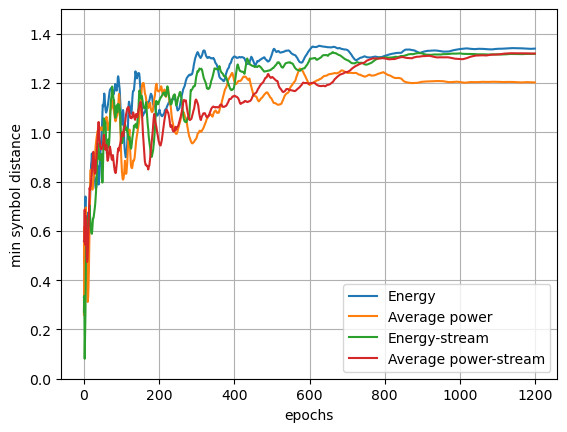

In [5]:
SIM_train.serial = (SIM_train.env_server == False) or (SIM_train.nworker == 1) or (len(model_list_AE) == 1)

### 訓練ループ
if SIM_train.serial:
    RES_train = []
    for i in range(len(model_list)):
        if model_list[i] == None:   # AEのときのみ訓練を行う
            continue
        normalize = normalize_name[normalize_list[i]]
        print(normalize)
        # 訓練
        RES = ae.train_model(SIM_train, model_list[i])
        # 結果保存
        RES.normalize = normalize
        RES_train.append(RES)
        # 結果表示
        print(RES.loss[-1], RES.distance[-1], RES.time,"[sec]")
    print()
else:
    with Pool(SIM_train.nworker) as p:
        RES_train = p.starmap(ae.train_model, [(SIM_train, model) for model in model_list_AE])

### 最小シンボル間距離表示
for RES in RES_train:
    print(RES.distance[-1])
print()

### 最小シンボル間距離グラフ
if SIM_train.env_server == False:
    for RES in RES_train:
        plt.plot(RES.distance, label=RES.normalize)
    plt.legend()
    plt.grid()
    plt.ylim([0, 1.5])
    plt.xlabel("epochs")
    plt.ylabel("min symbol distance")
    plt.show()

## テスト

QAM
0 [dB], nlooped = 1248 , noe = [1.705849e+06 1.000227e+06 1.248000e+03] , ER = [0.33370756 0.78267963 1.        ] , 1.188502311706543 [sec] 1.188502311706543 [sec]
3 [dB], nlooped = 1510 , noe = [1.573447e+06 1.000310e+06 1.510000e+03] , ER = [0.2543989  0.64693062 1.        ] , 1.4301509857177734 [sec] 2.6186532974243164 [sec]
6 [dB], nlooped = 2106 , noe = [1496715. 1000173.    2106.] , ER = [0.17350852 0.46378511 1.        ] , 1.8971176147460938 [sec] 4.51577091217041 [sec]
9 [dB], nlooped = 3705 , noe = [1438396. 1000381.    3689.] , ER = [0.09478297 0.26368005 0.99568151] , 3.4649977684020996 [sec] 7.98076868057251 [sec]
12 [dB], nlooped = 8147 , noe = [1426179. 1000188.    7548.] , ER = [0.04273821 0.11989028 0.926476  ] , 7.642181634902954 [sec] 15.622950315475464 [sec]
15 [dB], nlooped = 10000 , noe = [635769. 447368.   6447.] , ER = [0.0155217  0.04368828 0.6447    ] , 9.226486444473267 [sec] 24.84943675994873 [sec]
18 [dB], nlooped = 10000 , noe = [193873. 133941.   3128.

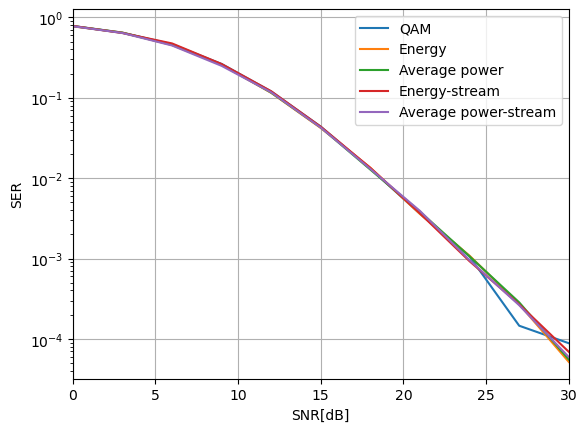

In [6]:
### テストループ
RES_test = []
for i in range(len(model_list)):
    normalize = normalize_name[normalize_list[i]]
    print(normalize)
    # テスト
    RES = ae.test_model(SIM_test, model_list[i])
    # 結果保存
    RES.normalize = normalize
    RES_test.append(RES)
    # 結果表示
    print(RES.time,"[sec]")
    print()

### SER特性 グラフ表示
if SIM_test.env_server == False:
    for RES in RES_test:
        plt.plot(SIM_test.EsN0Vec, RES.SER, label=RES.normalize)
    plt.legend()
    plt.grid()
    plt.yscale("log")
    plt.xlim([SIM_test.EsN0Vec[0], SIM_test.EsN0Vec[-1]])
    plt.xlabel("SNR[dB]")
    plt.ylabel("SER")
    plt.show()

# スプレッドシート転記用出力

In [7]:
# 正規化規則
for normalize in normalize_list:
    print(normalize, end=" ")
print()

# 最小シンボル間距離
for RES in RES_test:
    print(RES.distance, end=" ")
print()

# SER
for i in range(SIM_test.EsN0Vec.shape[0]):
    for RES in RES_test:
        print(RES.SER[i], end=" ")
    print()

0 1 2 3 4 
1.414213562373095 1.339921 1.2025827 1.318543 1.3197155 
0.7826796311598557 0.7745634100138669 0.7805955783246805 0.7834216181335204 0.7759785792295473 
0.6469306187913907 0.6467986858443708 0.643849328886693 0.6391863598249345 0.6396094261624099 
0.46378511173433046 0.4527908770862309 0.45638461959696264 0.4745353498542274 0.4473841724404489 
0.2636800459682861 0.25773749876286617 0.25947218924349097 0.2629903321890145 0.24954265736778233 
0.11989027786301706 0.11512047338890198 0.11582593983430163 0.12049342790062917 0.11683542351973684 
0.04368828125 0.04205732421875 0.0426908203125 0.0436123046875 0.04246533203125 
0.01308017578125 0.013461328125 0.0127560546875 0.01340009765625 0.013014453125 
0.0036025390625 0.003577734375 0.00381884765625 0.0036439453125 0.0039037109375 
0.001059375 0.00108203125 0.00106337890625 0.000923828125 0.00095185546875 
0.000145703125 0.00027041015625 0.000284375 0.0002685546875 0.0002623046875 
8.828125e-05 5.166015625e-05 5.52734375e-05 6.8